# BatFlightAnalysis

## Paquetes

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import shapiro

from BatFlightAnalysis import read_data, split_data

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Funciones

In [3]:
def curvatura(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    ddz = np.gradient(dz)

    # Calcular la curvatura
    curvatura = np.zeros(len(x))

    for i in range(len(x)):
        # Vectores de la primera y segunda derivada
        r_prime = np.array([dx[i], dy[i], dz[i]])
        r_double_prime = np.array([ddx[i], ddy[i], ddz[i]])
        
        # Producto cruzado de r' y r''
        cross_product = np.cross(r_prime, r_double_prime)
        
        # Magnitud de r'
        norm_r_prime = np.linalg.norm(r_prime)
        
        # Curvatura
        curvatura[i] = np.linalg.norm(cross_product) / (norm_r_prime**3)

    # Desviación Estándar de la curvatura
    std_curvatura = np.std(curvatura)

    # Media de la curvatura
    mean_curvatura = np.mean(curvatura)

    # Integral de la curvatura
    integral_curvatura = np.trapz(curvatura)

    return mean_curvatura, std_curvatura, integral_curvatura

def velocidad(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    # Calcular la magnitud de la velocidad en cada punto
    velocidad = np.zeros(len(x))
    for i in range(len(x)):
        r_prime = np.array([dx[i], dy[i], dz[i]])
        velocidad[i] = np.linalg.norm(r_prime)

    # Desviación Estándar de la velocidad
    std_velocidad = np.std(velocidad)

    # Media de la velocidad
    mean_velocidad = np.mean(velocidad)

    # Integral de la velocidad
    integral_velocidad = np.trapz(velocidad)

    return mean_velocidad, std_velocidad, integral_velocidad

def torsion(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Calcular las derivadas usando diferencias finitas
    dx = np.gradient(x)
    dy = np.gradient(y)
    dz = np.gradient(z)

    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    ddz = np.gradient(dz)

    dddx = np.gradient(ddx)
    dddy = np.gradient(ddy)
    dddz = np.gradient(ddz)

    # Calcular la torsión en cada punto
    torsion = np.zeros(len(x))
    for i in range(len(x)):
        r_prime = np.array([dx[i], dy[i], dz[i]])
        r_double_prime = np.array([ddx[i], ddy[i], ddz[i]])
        r_triple_prime = np.array([dddx[i], dddy[i], dddz[i]])

        # Producto cruzado de r' y r''
        cross_product = np.cross(r_prime, r_double_prime)
        
        # Torsión
        norm_cross_product = np.linalg.norm(cross_product)
        torsion[i] = np.dot(cross_product, r_triple_prime) / (norm_cross_product**2) if norm_cross_product != 0 else 0

    # Desviación Estándar de la torsión
    std_torsion = np.std(torsion)

    # Media de la torsión
    mean_torsion = np.mean(torsion)

    # Integral de la torsión
    integral_torsion = np.trapz(torsion)

    return mean_torsion, std_torsion, integral_torsion

In [4]:
def longitud(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    # Longitud de la trayectoria
    longitud = np.zeros(len(x))

    for i in range(1, len(x)):
        longitud[i] = longitud[i-1] + np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2 + (z[i] - z[i-1])**2)

    # Longitud total
    longitud_total = longitud[-1]

    return longitud_total

In [5]:
def var_espacial(df):
    # Convertir a arrays de numpy
    x = np.array(df['x'])
    y = np.array(df['y'])
    z = np.array(df['z'])

    longitud_x = np.max(x) - np.min(x)
    longitud_y = np.max(y) - np.min(y)
    longitud_z = np.max(z) - np.min(z)

    volumen = longitud_x * longitud_y * longitud_z

    return longitud_x, longitud_y, longitud_z, volumen


In [6]:
def hist_plots(whiskers_data, no_whiskers_data, metric):
    print(f"Histograms for {metric}:")
    # Perform normality check for "whiskers" and "no whiskers" groups and plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram for 'whiskers'
    axes[0].hist(whiskers_data[metric], bins=15, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Histogram of {metric} (Whiskers)')


    # Histogram for 'no whiskers'
    axes[1].hist(no_whiskers_data[metric], bins=15, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'Histogram of {metric} (No Whiskers)')

    plt.tight_layout()
    plt.show()

## Manejo de datos

In [7]:
# Lectura de los datos
data_bef, data_fee, data_aft = read_data('data/output_points_1_no_whiskers.xlsx')

# Split data into flower and bat data; before, during, and after feeding
flower_bef, flower_fee, flower_aft, bat_bef, bat_fee, bat_aft = split_data(data_bef, data_fee, data_aft)

# Show the data
print(flower_fee.head())

      x    y      z
9   281   94  349.0
10  283   98  345.0
11  283  100  341.0
12  283  103  338.0
13  288  103  336.0


In [8]:
individuo, whiskers, n_vuelo = [], [], []
mean_velocidad, std_velocidad, int_velocidad = [], [], []
mean_curvatura, std_curvatura, int_curvatura = [], [], []
mean_torsion, std_torsion, int_torsion = [], [], []
longitud_total = []
longitud_x, longitud_y, longitud_z, volumen = [], [], [], []

for n in range(6,10):
    # for tipo in ["Whiskers"]:
    for tipo in ["Whiskers", "No whiskers"]:
        # Recorro lo archivos de la capeta Individuo n
        for file in os.listdir(f'data/Individuo {n}/{tipo}'):
            # print("Procesando:", f"Individuo {n}/{tipo}/{file}")

            try:
                data_bef, data_fee, data_aft = read_data(f'data/Individuo {n}/{tipo}/{file}')

                # Split data into flower and bat data; before, during, and after feeding
                flower_bef, flower_fee, flower_aft, bat_bef, bat_fee, bat_aft = split_data(data_bef, data_fee, data_aft)

                # Velocidad
                mean_vel, std_vel, int_vel = velocidad(flower_fee)
                mean_velocidad.append(mean_vel)
                std_velocidad.append(std_vel)
                int_velocidad.append(int_vel)

                # Curvatura
                mean_curv, std_curv, int_curv = curvatura(flower_fee)
                mean_curvatura.append(mean_curv)
                std_curvatura.append(std_curv)
                int_curvatura.append(int_curv)

                # Torsión
                mean_tor, std_tor, int_tor = torsion(flower_fee)
                mean_torsion.append(mean_tor)
                std_torsion.append(std_tor)
                int_torsion.append(int_tor)

                # Longitud total
                long = longitud(flower_fee)
                longitud_total.append(long)

                # Variación en cada eje
                long_x, long_y, long_z, vol = var_espacial(flower_fee)
                longitud_x.append(long_x)
                longitud_y.append(long_y)
                longitud_z.append(long_z)
                volumen.append(vol)

                individuo.append(n)
                whiskers.append(tipo)
                n_vuelo.append(file.split('_')[-1].split('.')[0])
            except:
                print("Error en el archivo:", f"Individuo {n}/{tipo}/{file}")

# Creo el conjunto de datos
df = pd.DataFrame({
    'Individuo': individuo,
    'Tipo': whiskers,
    'No. Vuelo': n_vuelo,
    'Velocidad Media': mean_velocidad,
    'Desviación Estándar de la Velocidad': std_velocidad,
    'Integral de la Velocidad': int_velocidad,
    'Curvatura Media': mean_curvatura,
    'Desviación Estándar de la Curvatura': std_curvatura,
    'Integral de la Curvatura': int_curvatura,
    'Torsión Media': mean_torsion,
    'Desviación Estándar de la Torsión': std_torsion,
    'Integral de la Torsión': int_torsion,
    'Longitud Total': longitud_total,
    'Longitud en X': longitud_x,
    'Longitud en Y': longitud_y,
    'Longitud en Z': longitud_z,
    'Volumen': volumen
})

# Muestro los datos
display(df.head())

Error en el archivo: Individuo 6/No whiskers/output_points_7.xlsx


,Individuo,Tipo,No. Vuelo,Velocidad Media,Desviación Estándar de la Velocidad,Integral de la Velocidad,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Torsión Media,Desviación Estándar de la Torsión,Integral de la Torsión,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,3.685155,2.469856,62.346961,0.319137,0.309382,5.333128,-0.025381,0.120565,-0.422220,75.694841,18.0,14.0,19.0,4788.0
1,6,Whiskers,10,8.442801,5.213999,244.123139,0.061655,0.072966,1.756422,-0.022569,0.129216,-0.701873,260.010676,54.0,40.0,125.0,270000.0
2,6,Whiskers,11,3.832310,2.993198,62.419556,1.097282,3.454947,19.665025,-0.113609,0.256775,-2.043465,80.997540,7.0,21.0,18.0,2646.0
3,6,Whiskers,12,7.883429,3.940560,124.664154,0.128108,0.231968,2.129493,0.038921,0.102573,0.657215,131.251894,21.0,40.0,93.0,78120.0
4,6,Whiskers,13,3.654315,2.337232,47.331496,0.255117,0.302641,3.785561,0.012112,0.194771,0.167200,58.087628,10.0,11.0,16.0,1760.0


In [9]:
# Guardo los datos
df.to_excel('data/mediciones.xlsx', index=False)

## Análisis comparativo

In [10]:
# Leo el archivo de datos
data = pd.read_excel('data/mediciones.xlsx')

display(data.head())

,Individuo,Tipo,No. Vuelo,Velocidad Media,Desviación Estándar de la Velocidad,Integral de la Velocidad,Curvatura Media,Desviación Estándar de la Curvatura,Integral de la Curvatura,Torsión Media,Desviación Estándar de la Torsión,Integral de la Torsión,Longitud Total,Longitud en X,Longitud en Y,Longitud en Z,Volumen
0,6,Whiskers,1,3.685155,2.469856,62.346961,0.319137,0.309382,5.333128,-0.025381,0.120565,-0.422220,75.694841,18,14,19.0,4788.0
1,6,Whiskers,10,8.442801,5.213999,244.123139,0.061655,0.072966,1.756422,-0.022569,0.129216,-0.701873,260.010676,54,40,125.0,270000.0
2,6,Whiskers,11,3.832310,2.993198,62.419556,1.097282,3.454947,19.665025,-0.113609,0.256775,-2.043465,80.997540,7,21,18.0,2646.0
3,6,Whiskers,12,7.883429,3.940560,124.664154,0.128108,0.231968,2.129493,0.038921,0.102573,0.657215,131.251894,21,40,93.0,78120.0
4,6,Whiskers,13,3.654315,2.337232,47.331496,0.255117,0.302641,3.785561,0.012112,0.194771,0.167200,58.087628,10,11,16.0,1760.0


In [11]:
metrics = ['Velocidad Media', 'Desviación Estándar de la Velocidad', 'Integral de la Velocidad',
           'Curvatura Media', 'Desviación Estándar de la Curvatura', 'Integral de la Curvatura',
           'Torsión Media', 'Desviación Estándar de la Torsión', 'Integral de la Torsión',
           'Longitud Total', 'Longitud en X', 'Longitud en Y', 'Longitud en Z', 'Volumen']

data.columns = data.columns.str.replace(" ", "_")
metrics = [metric.replace(" ", "_") for metric in metrics]

### Análisis con pedicelo Estable

Histograms for Velocidad_Media:


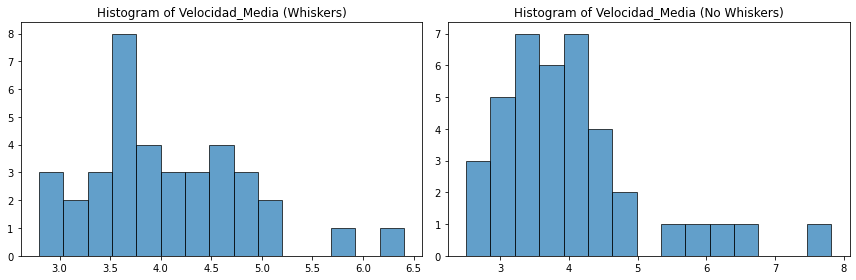

Histograms for Desviación_Estándar_de_la_Velocidad:


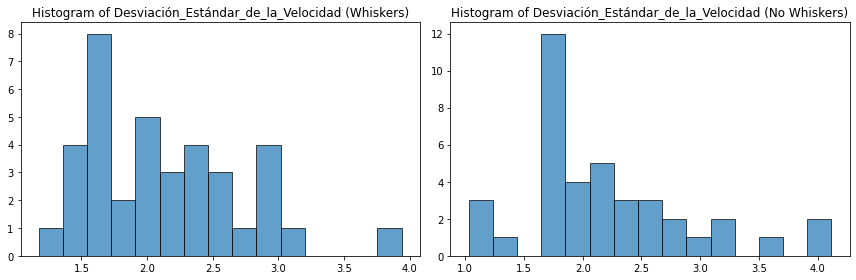

Histograms for Integral_de_la_Velocidad:


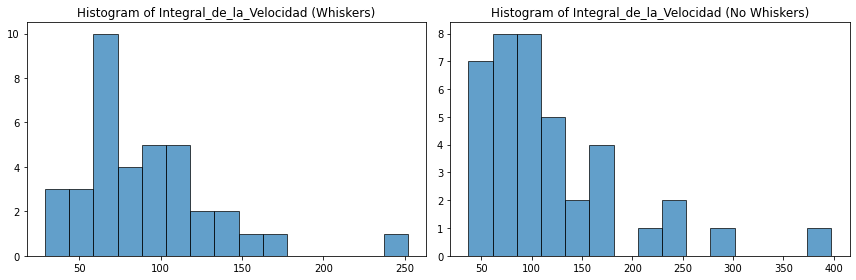

Histograms for Curvatura_Media:


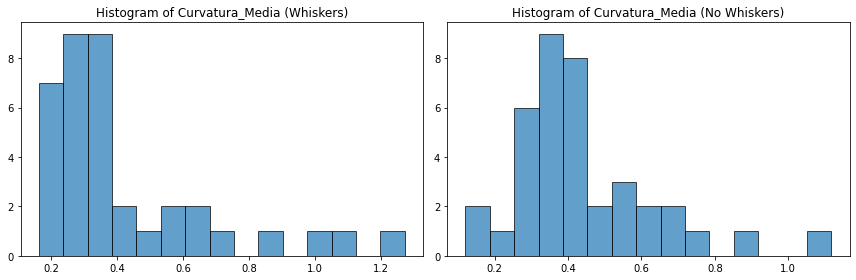

Histograms for Desviación_Estándar_de_la_Curvatura:


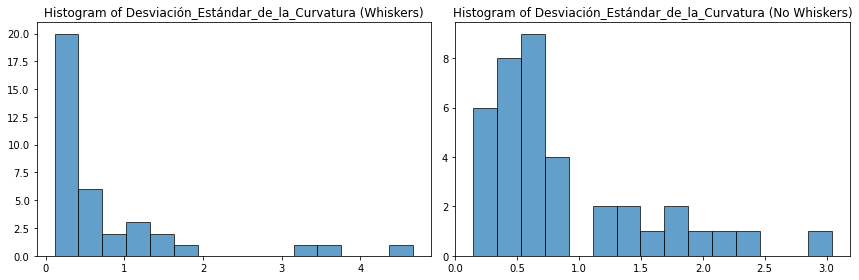

Histograms for Integral_de_la_Curvatura:


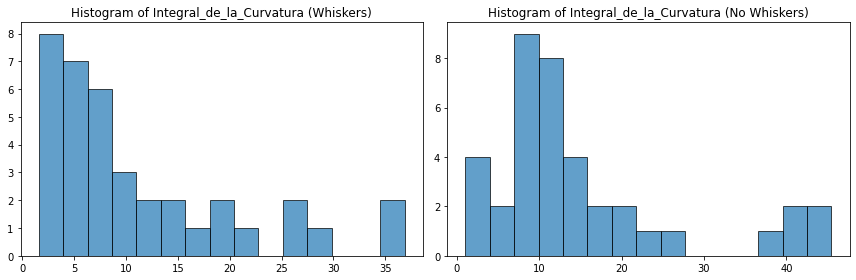

Histograms for Torsión_Media:


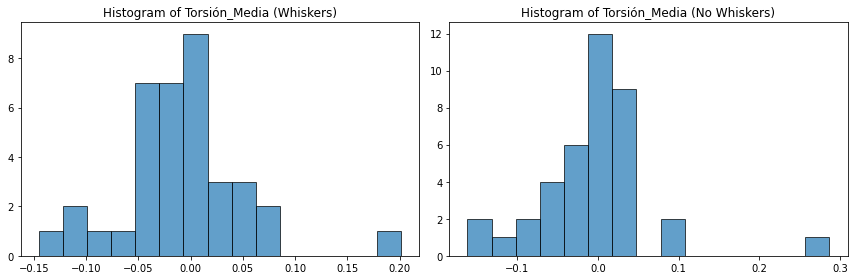

Histograms for Desviación_Estándar_de_la_Torsión:


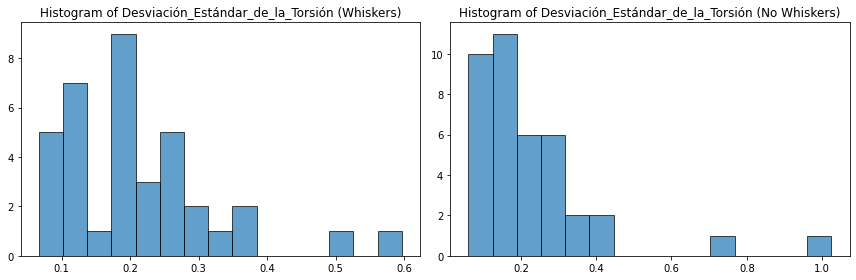

Histograms for Integral_de_la_Torsión:


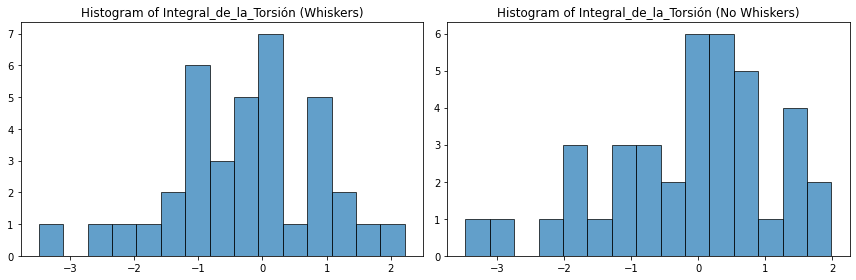

Histograms for Longitud_Total:


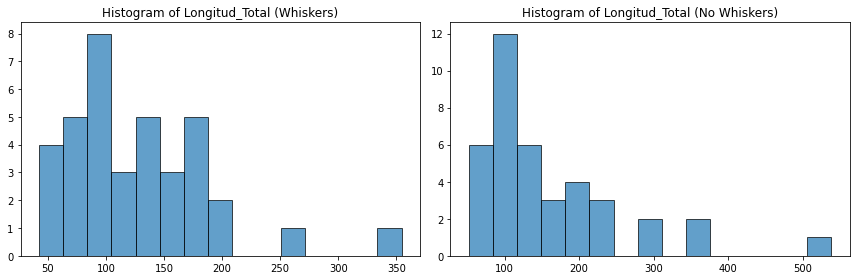

Histograms for Longitud_en_X:


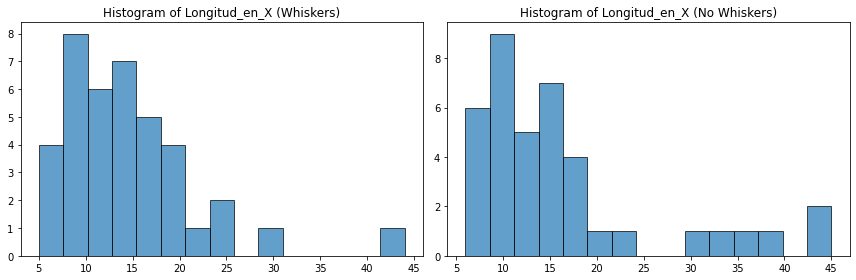

Histograms for Longitud_en_Y:


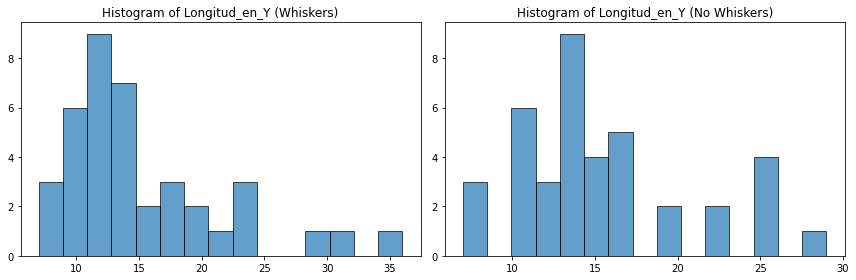

Histograms for Longitud_en_Z:


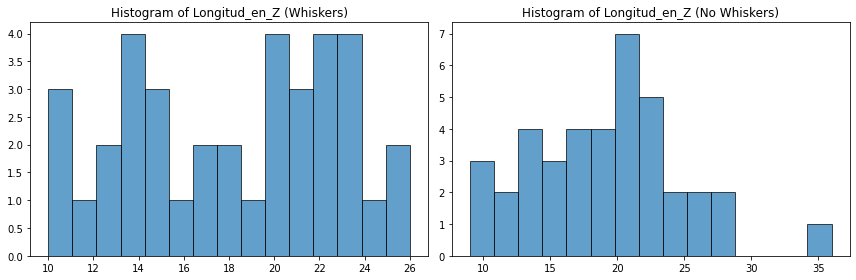

Histograms for Volumen:


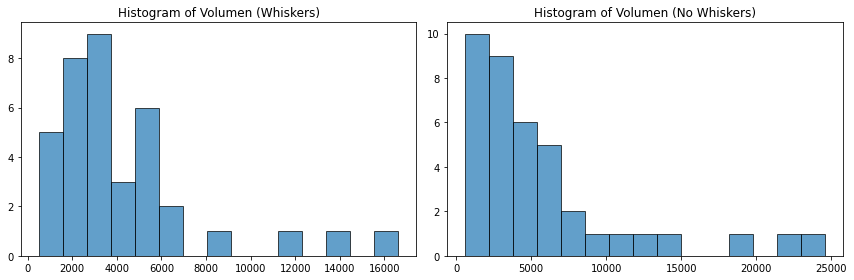

In [12]:
# Data estables, numéro de vuelo impares
data_estable = data[data['No._Vuelo'].astype(int) % 2 == 1]

# Separate data based on "Tipo" (whiskers or no whiskers)
whiskers_data = data_estable[data_estable['Tipo'] == 'Whiskers']
no_whiskers_data = data_estable[data_estable['Tipo'] == 'No whiskers']

for metric in metrics:
    hist_plots(whiskers_data, no_whiskers_data, metric)

#### Sin transformación logarítmica

In [13]:
for metric in metrics:
    print(f"=======================================================================")
    print(f"Modelo lineal mixto para {metric}:\n")

    # Limpiar datos: eliminar filas con valores nulos
    cleaned_data = data_estable.dropna(subset=[metric, "Tipo"])

    # Ajustar el modelo lineal mixto con la métrica transformada
    model = smf.mixedlm(f"{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Mostrar el resumen del modelo
    display(result.summary())

    # Si es significativo, coloco una estrella
    if result.pvalues[1] < 0.05:
        print(f"========")
        print("El efecto de 'Tipo' es significativo (p < 0.05)")
        print(f"========\n")

    # Obtener residuos y valores ajustados
    try:
        residuos = cleaned_data[metric] - result.fittedvalues
        # Revisar los residuos
        print("Revisión de residuos:")

        # Prueba de normalidad de Shapiro-Wilk
        stat, p = shapiro(residuos)
        if p > 0.05:
            print(f"Prueba de Shapiro-Wilk para los residuos de {metric}: Los residuos parecen normales.\n\n")
        else:
            print(f"Prueba de Shapiro-Wilk para los residuos de {metric}: Los residuos NO parecen normales.\n\n")
    except:
        print("Error al calcular residuos\n\n")



Modelo lineal mixto para Velocidad_Media:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Velocidad_Media
No. Observations: 76      Method:             REML           
No. Groups:       4       Scale:              0.8658         
Min. group size:  18      Log-Likelihood:     -105.0549      
Max. group size:  21      Converged:          Yes            
Mean group size:  19.0                                       
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           4.037    0.218 18.531 0.000  3.610  4.464
Tipo[T.Whiskers]    0.039    0.214  0.182 0.855 -0.380  0.458
Group Var           0.101    0.131                           
=============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Velocidad_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Velocidad
No. Observations: 76      Method:             REML                               
No. Groups:       4       Scale:              0.4284                             
Min. group size:  18      Log-Likelihood:     -78.2391                           
Max. group size:  21      Converged:          Yes                                
Mean group size:  19.0                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               2.189        0.127     17.248     0.000      1.940      2.438
Tipo[T.Whiskers]       -0.059        0.150     -0.395     0.693     -0.354      0.235
Group Var               0.020        0.053                                           
=================================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Desviación_Estándar_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Velocidad:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Velocidad
No. Observations: 76      Method:             REML                    
No. Groups:       4       Scale:              3460.5203               
Min. group size:  18      Log-Likelihood:     -412.2263               
Max. group size:  21      Converged:          Yes                     
Mean group size:  19.0                                                
-----------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept            119.397    14.986   7.967  0.000   90.026  148.769
Tipo[T.Whiskers]     -28.192    13.505  -2.088  0.037  -54.660   -1.723
Group Var            542.332    10.291                                 
======================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Integral_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Curvatura_Media:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Curvatura_Media
No. Observations: 75      Method:             REML           
No. Groups:       4       Scale:              0.0516         
Min. group size:  18      Log-Likelihood:     -0.5880        
Max. group size:  21      Converged:          Yes            
Mean group size:  18.8                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.447    0.051  8.723 0.000  0.346  0.547
Tipo[T.Whiskers]   -0.023    0.052 -0.445 0.656 -0.126  0.079
Group Var           0.005    0.029                           
=============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Curvatura_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Curvatura
No. Observations: 75      Method:             REML                               
No. Groups:       4       Scale:              0.6743                             
Min. group size:  18      Log-Likelihood:     -94.6716                           
Max. group size:  21      Converged:          Yes                                
Mean group size:  18.8                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.886        0.199      4.446     0.000      0.496      1.277
Tipo[T.Whiskers]       -0.079        0.190     -0.416     0.678     -0.451      0.293
Group Var               0.088        0.127                                           
=================================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Desviación_Estándar_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Curvatura:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Curvatura
No. Observations: 75      Method:             REML                    
No. Groups:       4       Scale:              104.1398                
Min. group size:  18      Log-Likelihood:     -278.5086               
Max. group size:  21      Converged:          Yes                     
Mean group size:  18.8                                                
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept           15.095      2.403    6.281   0.000   10.385   19.805
Tipo[T.Whiskers]    -4.038      2.357   -1.713   0.087   -8.658    0.582
Group Var           12.109      1.461                                   
======================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Integral_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Torsión_Media:



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Torsión_Media
No. Observations: 76      Method:             REML         
No. Groups:       4       Scale:              0.0043       
Min. group size:  18      Log-Likelihood:     inf          
Max. group size:  21      Converged:          Yes          
Mean group size:  19.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.000                                    
Tipo[T.Whiskers] -0.006    0.015 -0.398 0.691 -0.036  0.024
Group Var         0.000                                    
===========================================================

"""

Error al calcular residuos


Modelo lineal mixto para Desviación_Estándar_de_la_Torsión:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Torsión
No. Observations: 76      Method:             REML                             
No. Groups:       4       Scale:              0.0229                           
Min. group size:  18      Log-Likelihood:     inf                              
Max. group size:  21      Converged:          Yes                              
Mean group size:  19.0                                                         
-----------------------------------------------------------------------------------
                     Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept             0.000                                                        
Tipo[T.Whiskers]     -0.016        0.035     -0.467     0.641     -0.084      0.052
Group Var             0.000                                                        
===============================================================================

"""

Error al calcular residuos


Modelo lineal mixto para Integral_de_la_Torsión:



<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Torsión
No. Observations: 76      Method:             REML                  
No. Groups:       4       Scale:              1.4990                
Min. group size:  18      Log-Likelihood:     -123.9807             
Max. group size:  21      Converged:          Yes                   
Mean group size:  19.0                                              
---------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept             -0.138     0.210  -0.657  0.511  -0.549   0.273
Tipo[T.Whiskers]      -0.135     0.281  -0.480  0.631  -0.686   0.416
Group Var              0.022     0.065                               
====================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Integral_de_la_Torsión: Los residuos parecen normales.


Modelo lineal mixto para Longitud_Total:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM Dependent Variable: Longitud_Total
No. Observations:   76      Method:             REML          
No. Groups:         4       Scale:              6431.0519     
Min. group size:    18      Log-Likelihood:     -434.9764     
Max. group size:    21      Converged:          Yes           
Mean group size:    19.0                                      
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        159.421   19.476  8.186 0.000 121.249 197.593
Tipo[T.Whiskers] -32.251   18.409 -1.752 0.080 -68.333   3.831
Group Var        855.883   12.426                             
==============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_Total: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_X:



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_X
No. Observations: 78      Method:             REML         
No. Groups:       4       Scale:              44.8244      
Min. group size:  18      Log-Likelihood:     -260.5545    
Max. group size:  21      Converged:          Yes          
Mean group size:  19.5                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        16.806    3.538  4.750 0.000  9.872 23.741
Tipo[T.Whiskers] -2.041    1.517 -1.345 0.178 -5.014  0.932
Group Var        45.460    5.958                           
===========================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_en_X: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_Y:



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Y
No. Observations: 78      Method:             REML         
No. Groups:       4       Scale:              27.3563      
Min. group size:  18      Log-Likelihood:     -240.8666    
Max. group size:  21      Converged:          Yes          
Mean group size:  19.5                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.704    2.071  7.582 0.000 11.644 19.763
Tipo[T.Whiskers] -0.448    1.185 -0.378 0.706 -2.770  1.875
Group Var        14.344    2.519                           
===========================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_en_Y: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_Z:



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Z
No. Observations: 76      Method:             REML         
No. Groups:       4       Scale:              25.0515      
Min. group size:  18      Log-Likelihood:     -228.9013    
Max. group size:  21      Converged:          Yes          
Mean group size:  19.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        18.961    0.998 19.002 0.000 17.005 20.917
Tipo[T.Whiskers] -0.785    1.149 -0.683 0.495 -3.036  1.467
Group Var         1.408    0.462                           
===========================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_en_Z: Los residuos parecen normales.


Modelo lineal mixto para Volumen:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                MixedLM    Dependent Variable:    Volumen      
No. Observations:     76         Method:                REML         
No. Groups:           4          Scale:                 16163148.4069
Min. group size:      18         Log-Likelihood:        -726.5002    
Max. group size:      21         Converged:             Yes          
Mean group size:      19.0                                           
---------------------------------------------------------------------
                    Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept           5906.737 1661.407  3.555 0.000  2650.438 9163.035
Tipo[T.Whiskers]   -1691.692  922.936 -1.833 0.067 -3500.613  117.229
Group Var        9377604.069 2127.946                                
=====================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Volumen: Los residuos NO parecen normales.




#### Con transformación logarítmica

In [14]:
for metric in metrics:
    print(f"=======================================================================")
    print(f"Modelo lineal mixto para {metric} (con transformación logarítmica):\n")

    # Limpiar datos: eliminar filas con valores nulos
    cleaned_data = data_estable.dropna(subset=[metric, "Tipo"])

    # Manejar valores negativos: calcular constante de desplazamiento
    min_value = cleaned_data[metric].min()
    shift_constant = abs(min_value) + 1 if min_value < 0 else 0

    # Aplicar transformación logarítmica con desplazamiento
    cleaned_data[f"log_{metric}"] = np.log(cleaned_data[metric] + shift_constant)

    # Crear un identificador único para la combinación de 'Individuo' y 'No. Vuelo'
    cleaned_data["Grupo"] = cleaned_data["Individuo"].astype(str) + "_" + cleaned_data["No._Vuelo"].astype(str)

    # Ajustar el modelo lineal mixto con la métrica transformada
    model = smf.mixedlm(f"log_{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Mostrar el resumen del modelo
    display(result.summary())

    # Si es significativo, coloco una estrella
    if result.pvalues[1] < 0.05:
        print(f"========")
        print("El efecto de 'Tipo' es significativo (p < 0.05)")
        print(f"========\n")

    # Obtener residuos y valores ajustados
    try:
        residuos = cleaned_data[metric] - result.fittedvalues
        # Revisar los residuos
        print("Revisión de residuos:")

        # Prueba de normalidad de Shapiro-Wilk
        stat, p = shapiro(residuos)
        if p > 0.05:
            print(f"Prueba de Shapiro-Wilk para los residuos de log_{metric}: Los residuos parecen normales.\n\n")
        else:
            print(f"Prueba de Shapiro-Wilk para los residuos de log_{metric}: Los residuos NO parecen normales.\n\n")
    except:
        print("Error al calcular residuos\n\n")



Modelo lineal mixto para Velocidad_Media (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: log_Velocidad_Media
No. Observations: 76      Method:             REML               
No. Groups:       4       Scale:              0.0447             
Min. group size:  18      Log-Likelihood:     4.5820             
Max. group size:  21      Converged:          Yes                
Mean group size:  19.0                                           
------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept           1.364     0.050  27.335  0.000   1.266   1.462
Tipo[T.Whiskers]    0.024     0.049   0.487  0.626  -0.071   0.119
Group Var           0.005     0.030                               
=================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Velocidad_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:            MixedLM Dependent Variable: log_Desviación_Estándar_de_la_Velocidad
No. Observations: 76      Method:             REML                                   
No. Groups:       4       Scale:              0.0858                                 
Min. group size:  18      Log-Likelihood:     -19.0199                               
Max. group size:  21      Converged:          Yes                                    
Mean group size:  19.0                                                               
------------------------------------------------------------------------------------------
                       Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               0.733         0.061      12.084      0.000       0.615       0.852
Tipo[T.Whiskers]       -0.014         0.067      -0.209      0.834      -0.146       0.118
Group Var               0.006         0.029                                               
=====================================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Desviación_Estándar_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Velocidad (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: log_Integral_de_la_Velocidad
No. Observations: 76      Method:             REML                        
No. Groups:       4       Scale:              0.1945                      
Min. group size:  18      Log-Likelihood:     -51.3356                    
Max. group size:  21      Converged:          Yes                         
Mean group size:  19.0                                                    
-----------------------------------------------------------------------------
                    Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-----------------------------------------------------------------------------
Intercept            4.626       0.159    29.038    0.000     4.314     4.938
Tipo[T.Whiskers]    -0.213       0.101    -2.106    0.035    -0.412    -0.015
Group Var            0.081       0.174                                       
==========================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Integral_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Curvatura_Media (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: log_Curvatura_Media
No. Observations: 75      Method:             REML               
No. Groups:       4       Scale:              0.2105             
Min. group size:  18      Log-Likelihood:     -52.2569           
Max. group size:  21      Converged:          Yes                
Mean group size:  18.8                                           
------------------------------------------------------------------
                   Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept          -0.899     0.114  -7.898  0.000  -1.122  -0.676
Tipo[T.Whiskers]   -0.112     0.106  -1.055  0.291  -0.320   0.096
Group Var           0.030     0.075                               
=================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Curvatura_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:            MixedLM Dependent Variable: log_Desviación_Estándar_de_la_Curvatura
No. Observations: 75      Method:             REML                                   
No. Groups:       4       Scale:              0.5848                                 
Min. group size:  18      Log-Likelihood:     -89.6841                               
Max. group size:  21      Converged:          Yes                                    
Mean group size:  18.8                                                               
------------------------------------------------------------------------------------------
                       Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -0.388         0.196      -1.980      0.048      -0.772      -0.004
Tipo[T.Whiskers]       -0.285         0.177      -1.611      0.107      -0.631       0.062
Group Var               0.092         0.136                                               
=====================================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Desviación_Estándar_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Curvatura (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: log_Integral_de_la_Curvatura
No. Observations: 75      Method:             REML                        
No. Groups:       4       Scale:              0.5541                      
Min. group size:  18      Log-Likelihood:     -88.4232                    
Max. group size:  21      Converged:          Yes                         
Mean group size:  18.8                                                    
-----------------------------------------------------------------------------
                    Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-----------------------------------------------------------------------------
Intercept            2.419       0.233    10.397    0.000     1.963     2.875
Tipo[T.Whiskers]    -0.342       0.172    -1.988    0.047    -0.679    -0.005
Group Var            0.158       0.211                                       
==========================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Integral_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Torsión_Media (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Torsión_Media
No. Observations: 76      Method:             REML             
No. Groups:       4       Scale:              0.0031           
Min. group size:  18      Log-Likelihood:     inf              
Max. group size:  21      Converged:          Yes              
Mean group size:  19.0                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.000                                    
Tipo[T.Whiskers]     -0.005    0.013 -0.377 0.706 -0.030  0.020
Group Var             0.000                                    
===============================================================

"""

Error al calcular residuos


Modelo lineal mixto para Desviación_Estándar_de_la_Torsión (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:            MixedLM Dependent Variable: log_Desviación_Estándar_de_la_Torsión
No. Observations: 76      Method:             REML                                 
No. Groups:       4       Scale:              0.3146                               
Min. group size:  18      Log-Likelihood:     inf                                  
Max. group size:  21      Converged:          Yes                                  
Mean group size:  19.0                                                             
----------------------------------------------------------------------------------------
                      Coef.       Std.Err.        z        P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -0.000                                                            
Tipo[T.Whiskers]       0.000         0.129      0.001      0.999      -0.252       0.253
Group Var              0.000                                                            
===================================================================================

"""

Error al calcular residuos


Modelo lineal mixto para Integral_de_la_Torsión (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:            MixedLM Dependent Variable: log_Integral_de_la_Torsión
No. Observations: 76      Method:             REML                      
No. Groups:       4       Scale:              0.1304                    
Min. group size:  18      Log-Likelihood:     -33.7513                  
Max. group size:  21      Converged:          Yes                       
Mean group size:  19.0                                                  
--------------------------------------------------------------------------
                      Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------
Intercept              1.412      0.063   22.314   0.000    1.288    1.536
Tipo[T.Whiskers]      -0.023      0.083   -0.281   0.779   -0.186    0.139
Group Var              0.003      0.021                                   
========================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Integral_de_la_Torsión: Los residuos parecen normales.


Modelo lineal mixto para Longitud_Total (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:            MixedLM Dependent Variable: log_Longitud_Total
No. Observations: 76      Method:             REML              
No. Groups:       4       Scale:              0.2013            
Min. group size:  18      Log-Likelihood:     -52.3818          
Max. group size:  21      Converged:          Yes               
Mean group size:  19.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          4.920     0.151  32.525  0.000   4.624   5.217
Tipo[T.Whiskers]  -0.181     0.103  -1.762  0.078  -0.383   0.020
Group Var          0.071     0.151                               
================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_Total: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_X (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Longitud_en_X
No. Observations: 78      Method:             REML             
No. Groups:       4       Scale:              0.1430           
Min. group size:  18      Log-Likelihood:     -41.9019         
Max. group size:  21      Converged:          Yes              
Mean group size:  19.5                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.673    0.186 14.394 0.000  2.309  3.037
Tipo[T.Whiskers]     -0.083    0.086 -0.974 0.330 -0.251  0.084
Group Var             0.123    0.289                           
===============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_en_X: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_Y (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Longitud_en_Y
No. Observations: 78      Method:             REML             
No. Groups:       4       Scale:              0.0993           
Min. group size:  18      Log-Likelihood:     -27.2911         
Max. group size:  21      Converged:          Yes              
Mean group size:  19.5                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.698    0.122 22.086 0.000  2.459  2.938
Tipo[T.Whiskers]     -0.057    0.071 -0.801 0.423 -0.197  0.083
Group Var             0.049    0.145                           
===============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_en_Y: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_Z (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Longitud_en_Z
No. Observations: 76      Method:             REML             
No. Groups:       4       Scale:              0.0791           
Min. group size:  18      Log-Likelihood:     -16.0374         
Max. group size:  21      Converged:          Yes              
Mean group size:  19.0                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.897    0.058 49.698 0.000  2.783  3.012
Tipo[T.Whiskers]     -0.030    0.065 -0.458 0.647 -0.156  0.097
Group Var             0.005    0.029                           
===============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_en_Z: Los residuos parecen normales.


Modelo lineal mixto para Volumen (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM Dependent Variable: log_Volumen
No. Observations:   76      Method:             REML       
No. Groups:         4       Scale:              0.5222     
Min. group size:    18      Log-Likelihood:     -88.1884   
Max. group size:    21      Converged:          Yes        
Mean group size:    19.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         8.267    0.286 28.863 0.000  7.706  8.829
Tipo[T.Whiskers] -0.191    0.166 -1.149 0.251 -0.516  0.135
Group Var         0.274    0.349                           
===========================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Volumen: Los residuos NO parecen normales.




### Análisis con pedicelo Flexible

Histograms for Velocidad_Media:


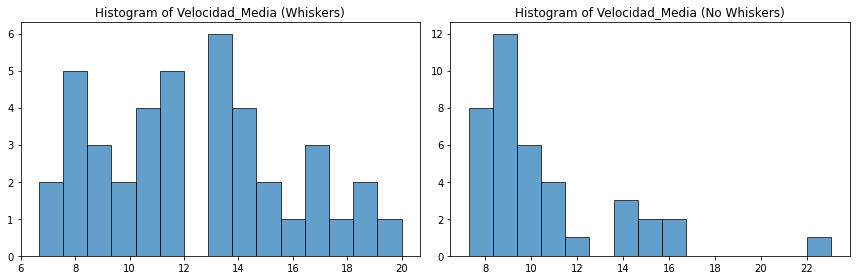

Histograms for Desviación_Estándar_de_la_Velocidad:


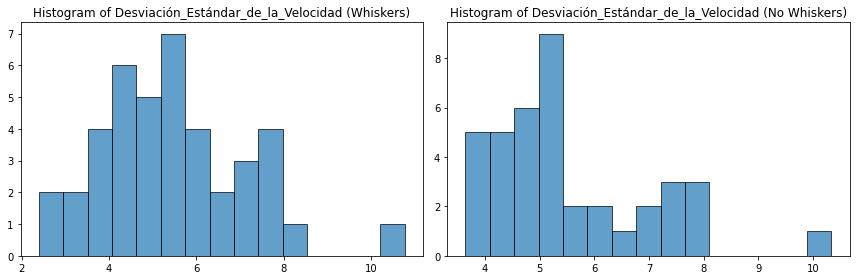

Histograms for Integral_de_la_Velocidad:


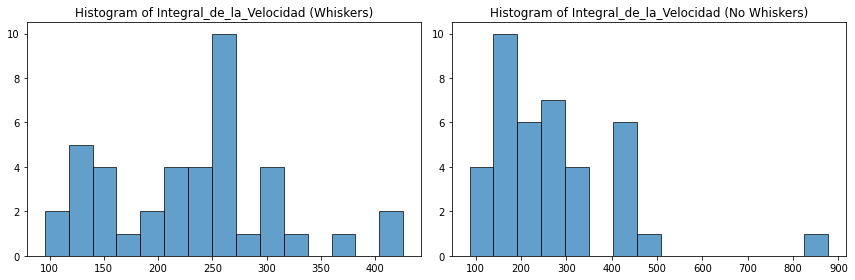

Histograms for Curvatura_Media:


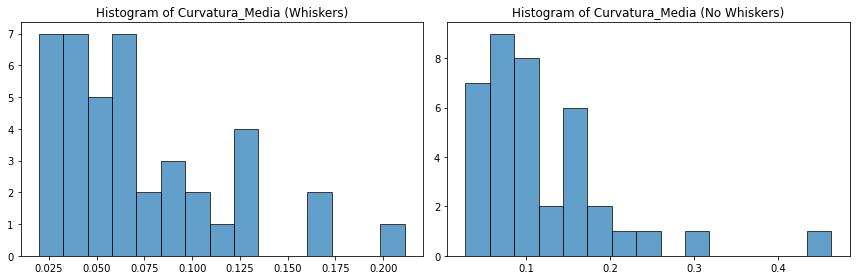

Histograms for Desviación_Estándar_de_la_Curvatura:


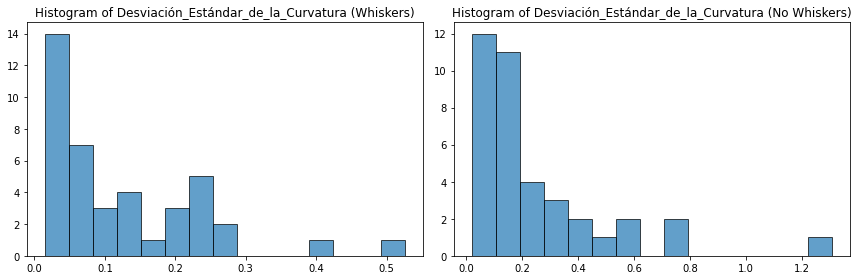

Histograms for Integral_de_la_Curvatura:


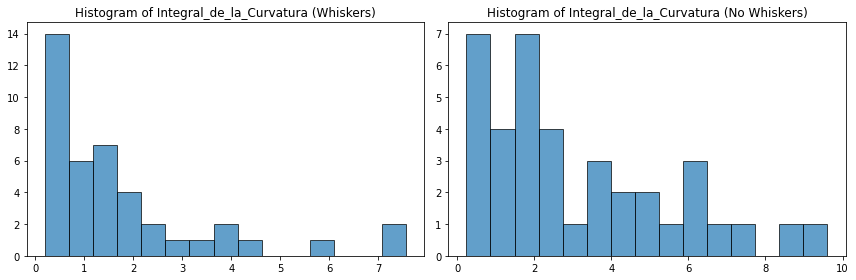

Histograms for Torsión_Media:


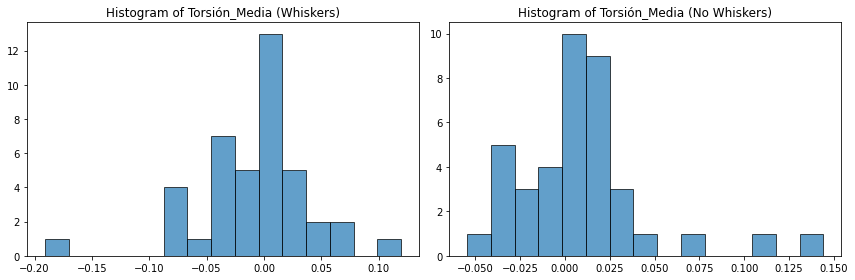

Histograms for Desviación_Estándar_de_la_Torsión:


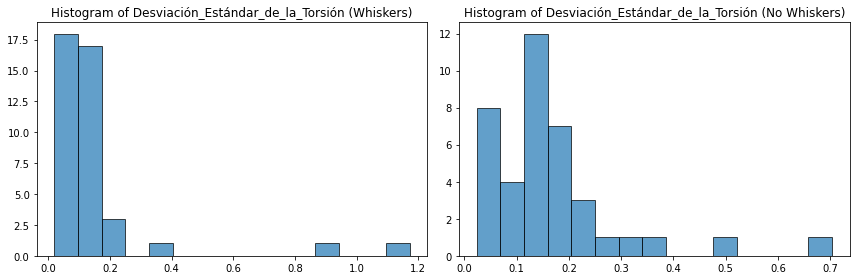

Histograms for Integral_de_la_Torsión:


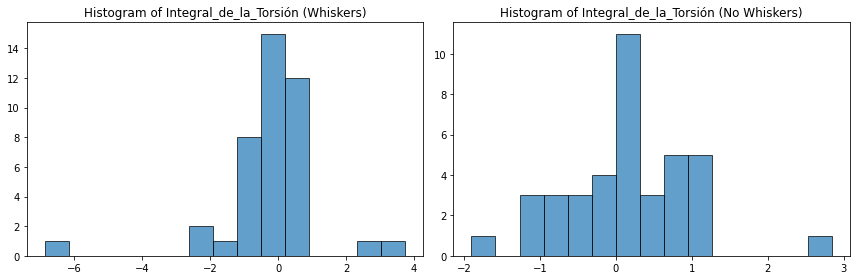

Histograms for Longitud_Total:


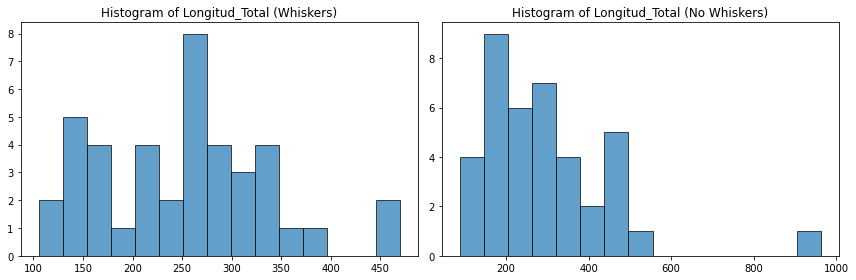

Histograms for Longitud_en_X:


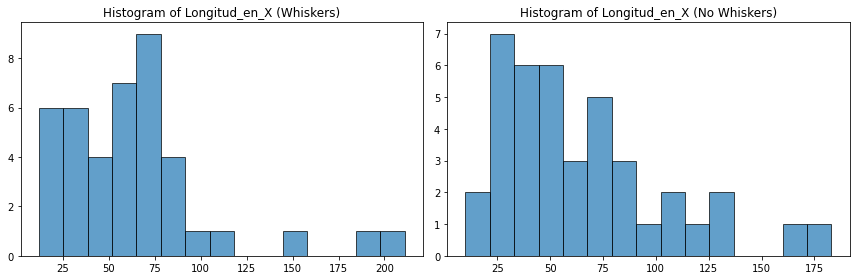

Histograms for Longitud_en_Y:


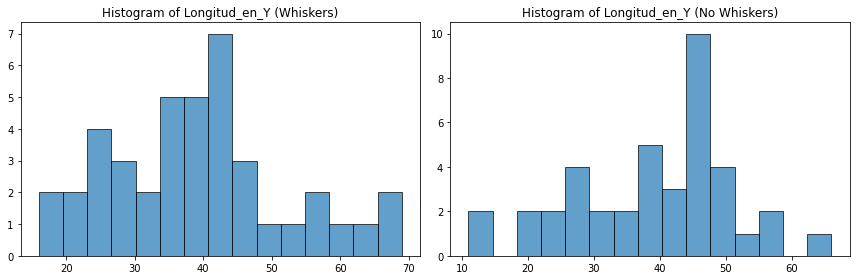

Histograms for Longitud_en_Z:


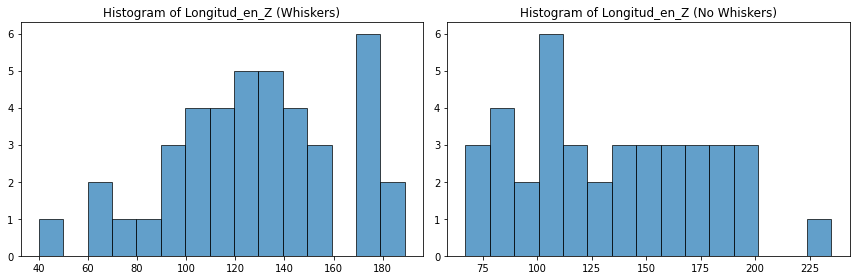

Histograms for Volumen:


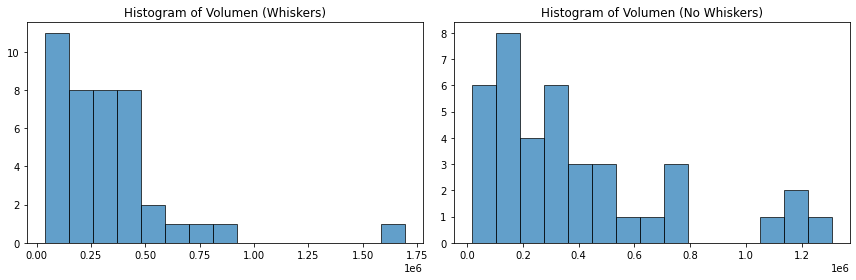

In [15]:
# Data estables, numéro de vuelo pares
data_flexible = data[data['No._Vuelo'].astype(int) % 2 == 0]

# Separate data based on "Tipo" (whiskers or no whiskers)
whiskers_data = data_flexible[data_flexible['Tipo'] == 'Whiskers']
no_whiskers_data = data_flexible[data_flexible['Tipo'] == 'No whiskers']

for metric in metrics:
    hist_plots(whiskers_data, no_whiskers_data, metric)

#### Sin transformación logarítmica

In [16]:
for metric in metrics:
    print(f"=======================================================================")
    print(f"Modelo lineal mixto para {metric}:\n")

    # Limpiar datos: eliminar filas con valores nulos
    cleaned_data = data_flexible.dropna(subset=[metric, "Tipo"])

    # Ajustar el modelo lineal mixto con la métrica transformada
    model = smf.mixedlm(f"{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Mostrar el resumen del modelo
    display(result.summary())

    # Si es significativo, coloco una estrella
    if result.pvalues[1] < 0.05:
        print(f"========")
        print("El efecto de 'Tipo' es significativo (p < 0.05)")
        print(f"========\n")

    # Obtener residuos y valores ajustados
    try:
        residuos = cleaned_data[metric] - result.fittedvalues
        # Revisar los residuos
        print("Revisión de residuos:")

        # Prueba de normalidad de Shapiro-Wilk
        stat, p = shapiro(residuos)
        if p > 0.05:
            print(f"Prueba de Shapiro-Wilk para los residuos de {metric}: Los residuos parecen normales.\n\n")
        else:
            print(f"Prueba de Shapiro-Wilk para los residuos de {metric}: Los residuos NO parecen normales.\n\n")
    except:
        print("Error al calcular residuos\n\n")



Modelo lineal mixto para Velocidad_Media:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Velocidad_Media
No. Observations: 80      Method:             REML           
No. Groups:       4       Scale:              9.7541         
Min. group size:  20      Log-Likelihood:     -206.0630      
Max. group size:  20      Converged:          Yes            
Mean group size:  20.0                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          10.494    0.976 10.747 0.000  8.580 12.408
Tipo[T.Whiskers]    1.957    0.699  2.799 0.005  0.587  3.328
Group Var           2.813    0.880                           
=============================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Velocidad_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Velocidad
No. Observations: 80      Method:             REML                               
No. Groups:       4       Scale:              2.5441                             
Min. group size:  20      Log-Likelihood:     -150.9914                          
Max. group size:  20      Converged:          No                                 
Mean group size:  20.0                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               5.535        0.265     20.847     0.000      5.014      6.055
Tipo[T.Whiskers]       -0.111        0.360     -0.308     0.758     -0.815      0.594
Group Var               0.019        0.298                                           
=================================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Desviación_Estándar_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Velocidad:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Velocidad
No. Observations: 80      Method:             REML                    
No. Groups:       4       Scale:              13319.9858              
Min. group size:  20      Log-Likelihood:     -484.7681               
Max. group size:  20      Converged:          No                      
Mean group size:  20.0                                                
-----------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept            269.336    18.537  14.530  0.000  233.004  305.667
Tipo[T.Whiskers]     -36.306    25.816  -1.406  0.160  -86.904   14.291
Group Var              8.269     4.601                                 
======================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Integral_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Curvatura_Media:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Curvatura_Media
No. Observations: 79      Method:             REML           
No. Groups:       4       Scale:              0.0040         
Min. group size:  19      Log-Likelihood:     97.6599        
Max. group size:  20      Converged:          Yes            
Mean group size:  19.8                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.119    0.015  7.845 0.000  0.089  0.148
Tipo[T.Whiskers]   -0.047    0.014 -3.300 0.001 -0.075 -0.019
Group Var           0.000    0.009                           
=============================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Curvatura_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Curvatura
No. Observations: 79      Method:             REML                               
No. Groups:       4       Scale:              0.0362                             
Min. group size:  19      Log-Likelihood:     13.2819                            
Max. group size:  20      Converged:          Yes                                
Mean group size:  19.8                                                           
-------------------------------------------------------------------------------------
                       Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------------
Intercept               0.251        0.043      5.882     0.000      0.168      0.335
Tipo[T.Whiskers]       -0.123        0.043     -2.881     0.004     -0.207     -0.039
Group Var               0.003        0.023                                           
=================================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Desviación_Estándar_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Curvatura:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:            MixedLM Dependent Variable: Integral_de_la_Curvatura
No. Observations: 79      Method:             REML                    
No. Groups:       4       Scale:              3.7730                  
Min. group size:  19      Log-Likelihood:     -166.9142               
Max. group size:  20      Converged:          Yes                     
Mean group size:  19.8                                                
------------------------------------------------------------------------
                    Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------------
Intercept            3.154      0.611    5.166   0.000    1.957    4.351
Tipo[T.Whiskers]    -1.428      0.438   -3.261   0.001   -2.285   -0.570
Group Var            1.094      0.552                                   
======================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Integral_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Torsión_Media:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM    Dependent Variable:    Torsión_Media
No. Observations:      80         Method:                REML         
No. Groups:            4          Scale:                 0.0020       
Min. group size:       20         Log-Likelihood:        inf          
Max. group size:       20         Converged:             Yes          
Mean group size:       20.0                                           
----------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
----------------------------------------------------------------------
Intercept        -0.000 472075.823 -0.000 1.000 -925251.612 925251.612
Tipo[T.Whiskers] -0.016      0.010 -1.606 0.108      -0.036      0.004
Group Var         0.000                                               
======================================================================

"""

Error al calcular residuos


Modelo lineal mixto para Desviación_Estándar_de_la_Torsión:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:            MixedLM Dependent Variable: Desviación_Estándar_de_la_Torsión
No. Observations: 80      Method:             REML                             
No. Groups:       4       Scale:              0.0298                           
Min. group size:  20      Log-Likelihood:     21.3001                          
Max. group size:  20      Converged:          Yes                              
Mean group size:  20.0                                                         
-----------------------------------------------------------------------------------
                     Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept             0.165        0.037      4.502     0.000      0.093      0.236
Tipo[T.Whiskers]     -0.011        0.039     -0.280     0.779     -0.086      0.065
Group Var             0.002        0.018                                           
===============================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Desviación_Estándar_de_la_Torsión: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Torsión:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                MixedLM   Dependent Variable:   Integral_de_la_Torsión
No. Observations:     80        Method:               REML                  
No. Groups:           4         Scale:                1.4474                
Min. group size:      20        Log-Likelihood:       inf                   
Max. group size:      20        Converged:            Yes                   
Mean group size:      20.0                                                  
----------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025       0.975]   
----------------------------------------------------------------------------
Intercept        -0.000 12765887.742 -0.000 1.000 -25020680.206 25020680.206
Tipo[T.Whiskers] -0.338        0.269 -1.255 0.210        -0.866        0.190
Group Var         0.000                                                     
============================================================================

"""

Error al calcular residuos


Modelo lineal mixto para Longitud_Total:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM Dependent Variable: Longitud_Total
No. Observations:   80      Method:             REML          
No. Groups:         4       Scale:              16153.7271    
Min. group size:    20      Log-Likelihood:     -492.5057     
Max. group size:    20      Converged:          Yes           
Mean group size:    20.0                                      
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        294.870   21.174 13.926 0.000 253.371 336.369
Tipo[T.Whiskers] -40.954   28.434 -1.440 0.150 -96.684  14.775
Group Var        136.174    6.184                             
==============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_Total: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_X:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM Dependent Variable: Longitud_en_X
No. Observations:   81      Method:             REML         
No. Groups:         4       Scale:              1433.3030    
Min. group size:    20      Log-Likelihood:     -405.1706    
Max. group size:    21      Converged:          Yes          
Mean group size:    20.2                                     
-------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------
Intercept         65.325   10.001  6.532 0.000  45.723 84.927
Tipo[T.Whiskers]  -0.475    8.415 -0.056 0.955 -16.968 16.019
Group Var        256.777    7.222                            
=============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_en_X: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_Y:



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Longitud_en_Y
No. Observations: 81      Method:             REML         
No. Groups:       4       Scale:              121.9397     
Min. group size:  20      Log-Likelihood:     -308.8642    
Max. group size:  21      Converged:          Yes          
Mean group size:  20.2                                     
-----------------------------------------------------------
                  Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         38.825    3.923 9.898 0.000 31.137 46.513
Tipo[T.Whiskers]   0.553    2.455 0.225 0.822 -4.258  5.364
Group Var         49.351    4.178                          
===========================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_en_Y: Los residuos parecen normales.


Modelo lineal mixto para Longitud_en_Z:



<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:             MixedLM  Dependent Variable:  Longitud_en_Z
No. Observations:  80       Method:              REML         
No. Groups:        4        Scale:               1081.1459    
Min. group size:   20       Log-Likelihood:      -390.4247    
Max. group size:   20       Converged:           Yes          
Mean group size:   20.0                                       
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        135.318   12.832 10.546 0.000 110.168 160.467
Tipo[T.Whiskers]  -8.132    7.361 -1.105 0.269 -22.560   6.296
Group Var        547.624   15.237                             
==============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Longitud_en_Z: Los residuos parecen normales.


Modelo lineal mixto para Volumen:



<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM      Dependent Variable:      Volumen         
No. Observations:      80           Method:                  REML            
No. Groups:            4            Scale:                   93076572784.5022
Min. group size:       20           Log-Likelihood:          -1100.7616      
Max. group size:       20           Converged:               No              
Mean group size:       20.0                                                  
-----------------------------------------------------------------------------
                     Coef.       Std.Err.   z    P>|z|    [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept            389309.687 64458.847  6.040 0.000  262972.668 515646.706
Tipo[T.Whiskers]     -56927.975 68282.929 -0.834 0.404 -190760.057  76904.108
Group Var        7067342698.947 29407.807                                    
=============================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de Volumen: Los residuos NO parecen normales.




#### Con transformación logarítmica

In [17]:
for metric in metrics:
    print(f"=======================================================================")
    print(f"Modelo lineal mixto para {metric} (con transformación logarítmica):\n")

    # Limpiar datos: eliminar filas con valores nulos
    cleaned_data = data_flexible.dropna(subset=[metric, "Tipo"])

    # Manejar valores negativos: calcular constante de desplazamiento
    min_value = cleaned_data[metric].min()
    shift_constant = abs(min_value) + 1 if min_value < 0 else 0

    # Aplicar transformación logarítmica con desplazamiento
    cleaned_data[f"log_{metric}"] = np.log(cleaned_data[metric] + shift_constant)

    # Crear un identificador único para la combinación de 'Individuo' y 'No. Vuelo'
    cleaned_data["Grupo"] = cleaned_data["Individuo"].astype(str) + "_" + cleaned_data["No._Vuelo"].astype(str)

    # Ajustar el modelo lineal mixto con la métrica transformada
    model = smf.mixedlm(f"log_{metric} ~ Tipo", cleaned_data, groups=cleaned_data["Individuo"])
    result = model.fit()

    # Mostrar el resumen del modelo
    display(result.summary())

    # Si es significativo, coloco una estrella
    if result.pvalues[1] < 0.05:
        print(f"========")
        print("El efecto de 'Tipo' es significativo (p < 0.05)")
        print(f"========\n")

    # Obtener residuos y valores ajustados
    try:
        residuos = cleaned_data[metric] - result.fittedvalues
        # Revisar los residuos
        print("Revisión de residuos:")

        # Prueba de normalidad de Shapiro-Wilk
        stat, p = shapiro(residuos)
        if p > 0.05:
            print(f"Prueba de Shapiro-Wilk para los residuos de log_{metric}: Los residuos parecen normales.\n\n")
        else:
            print(f"Prueba de Shapiro-Wilk para los residuos de log_{metric}: Los residuos NO parecen normales.\n\n")
    except:
        print("Error al calcular residuos\n\n")



Modelo lineal mixto para Velocidad_Media (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: log_Velocidad_Media
No. Observations: 80      Method:             REML               
No. Groups:       4       Scale:              0.0652             
Min. group size:  20      Log-Likelihood:     -10.7924           
Max. group size:  20      Converged:          Yes                
Mean group size:  20.0                                           
------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept           2.313     0.081  28.604  0.000   2.155   2.472
Tipo[T.Whiskers]    0.166     0.057   2.908  0.004   0.054   0.278
Group Var           0.019     0.074                               
=================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Velocidad_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Velocidad (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:            MixedLM Dependent Variable: log_Desviación_Estándar_de_la_Velocidad
No. Observations: 80      Method:             REML                                   
No. Groups:       4       Scale:              0.0811                                 
Min. group size:  20      Log-Likelihood:     inf                                    
Max. group size:  20      Converged:          Yes                                    
Mean group size:  20.0                                                               
---------------------------------------------------------------------------------------
                     Coef.      Std.Err.      z      P>|z|      [0.025         0.975]  
---------------------------------------------------------------------------------------
Intercept            -0.000   3021621.392   -0.000   1.000   -5922269.103   5922269.103
Tipo[T.Whiskers]     -0.036         0.064   -0.569   0.569         -0.161         0.089
Group Var             0.000                                                            
=====================================================================================

"""

Error al calcular residuos


Modelo lineal mixto para Integral_de_la_Velocidad (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: log_Integral_de_la_Velocidad
No. Observations: 80      Method:             REML                        
No. Groups:       4       Scale:              0.1599                      
Min. group size:  20      Log-Likelihood:     -44.5691                    
Max. group size:  20      Converged:          Yes                         
Mean group size:  20.0                                                    
-----------------------------------------------------------------------------
                    Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-----------------------------------------------------------------------------
Intercept            5.484       0.091    60.175    0.000     5.306     5.663
Tipo[T.Whiskers]    -0.094       0.090    -1.045    0.296    -0.269     0.082
Group Var            0.017       0.052                                       
==========================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Integral_de_la_Velocidad: Los residuos NO parecen normales.


Modelo lineal mixto para Curvatura_Media (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: log_Curvatura_Media
No. Observations: 79      Method:             REML               
No. Groups:       4       Scale:              0.3672             
Min. group size:  19      Log-Likelihood:     -75.6352           
Max. group size:  20      Converged:          Yes                
Mean group size:  19.8                                           
------------------------------------------------------------------
                  Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept         -2.329     0.126  -18.490  0.000  -2.576  -2.082
Tipo[T.Whiskers]  -0.492     0.137   -3.605  0.000  -0.760  -0.225
Group Var          0.025     0.060                                
=================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Curvatura_Media: Los residuos NO parecen normales.


Modelo lineal mixto para Desviación_Estándar_de_la_Curvatura (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:            MixedLM Dependent Variable: log_Desviación_Estándar_de_la_Curvatura
No. Observations: 79      Method:             REML                                   
No. Groups:       4       Scale:              0.8345                                 
Min. group size:  19      Log-Likelihood:     -107.1169                              
Max. group size:  20      Converged:          Yes                                    
Mean group size:  19.8                                                               
------------------------------------------------------------------------------------------
                       Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.796         0.185      -9.719      0.000      -2.158      -1.434
Tipo[T.Whiskers]       -0.655         0.206      -3.184      0.001      -1.059      -0.252
Group Var               0.049         0.083                                               
=====================================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Desviación_Estándar_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Curvatura (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: log_Integral_de_la_Curvatura
No. Observations: 79      Method:             REML                        
No. Groups:       4       Scale:              0.7217                      
Min. group size:  19      Log-Likelihood:     -103.6105                   
Max. group size:  20      Converged:          Yes                         
Mean group size:  19.8                                                    
-----------------------------------------------------------------------------
                    Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
-----------------------------------------------------------------------------
Intercept            0.795       0.298     2.667    0.008     0.211     1.379
Tipo[T.Whiskers]    -0.724       0.191    -3.779    0.000    -1.099    -0.348
Group Var            0.279       0.311                                       
==========================================================================

"""

El efecto de 'Tipo' es significativo (p < 0.05)

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Integral_de_la_Curvatura: Los residuos NO parecen normales.


Modelo lineal mixto para Torsión_Media (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:               MixedLM   Dependent Variable:   log_Torsión_Media
No. Observations:    80        Method:               REML             
No. Groups:          4         Scale:                0.0014           
Min. group size:     20        Log-Likelihood:       inf              
Max. group size:     20        Converged:            Yes              
Mean group size:     20.0                                             
----------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
----------------------------------------------------------------------
Intercept        -0.000 399593.665 -0.000 1.000 -783189.192 783189.192
Tipo[T.Whiskers] -0.014      0.008 -1.647 0.100      -0.030      0.003
Group Var         0.000                                               
======================================================================

"""

Error al calcular residuos


Modelo lineal mixto para Desviación_Estándar_de_la_Torsión (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:            MixedLM Dependent Variable: log_Desviación_Estándar_de_la_Torsión
No. Observations: 80      Method:             REML                                 
No. Groups:       4       Scale:              0.5306                               
Min. group size:  20      Log-Likelihood:     -92.5315                             
Max. group size:  20      Converged:          Yes                                  
Mean group size:  20.0                                                             
---------------------------------------------------------------------------------------
                         Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
---------------------------------------------------------------------------------------
Intercept                -2.059        0.229     -9.004     0.000     -2.507     -1.610
Tipo[T.Whiskers]         -0.240        0.163     -1.472     0.141     -0.560      0.080
Group Var                 0.155        0.207                                           
===================================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Desviación_Estándar_de_la_Torsión: Los residuos NO parecen normales.


Modelo lineal mixto para Integral_de_la_Torsión (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:            MixedLM Dependent Variable: log_Integral_de_la_Torsión
No. Observations: 80      Method:             REML                      
No. Groups:       4       Scale:              0.0657                    
Min. group size:  20      Log-Likelihood:     -8.3740                   
Max. group size:  20      Converged:          No                        
Mean group size:  20.0                                                  
--------------------------------------------------------------------------
                      Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------
Intercept              2.073      0.043   48.665   0.000    1.989    2.156
Tipo[T.Whiskers]      -0.074      0.057   -1.288   0.198   -0.186    0.039
Group Var              0.001      0.066                                   
========================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Integral_de_la_Torsión: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_Total (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:            MixedLM Dependent Variable: log_Longitud_Total
No. Observations: 80      Method:             REML              
No. Groups:       4       Scale:              0.1642            
Min. group size:  20      Log-Likelihood:     -45.7529          
Max. group size:  20      Converged:          Yes               
Mean group size:  20.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          5.573     0.096  58.151  0.000   5.385   5.761
Tipo[T.Whiskers]  -0.099     0.091  -1.096  0.273  -0.277   0.078
Group Var          0.020     0.058                               
================================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_Total: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_X (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Longitud_en_X
No. Observations: 81      Method:             REML             
No. Groups:       4       Scale:              0.3135           
Min. group size:  20      Log-Likelihood:     -72.6550         
Max. group size:  21      Converged:          Yes              
Mean group size:  20.2                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.006    0.164 24.360 0.000  3.684  4.329
Tipo[T.Whiskers]     -0.011    0.124 -0.092 0.927 -0.255  0.232
Group Var             0.077    0.138                           
===============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_en_X: Los residuos NO parecen normales.


Modelo lineal mixto para Longitud_en_Y (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Longitud_en_Y
No. Observations: 81      Method:             REML             
No. Groups:       4       Scale:              0.1064           
Min. group size:  20      Log-Likelihood:     -30.5245         
Max. group size:  21      Converged:          Yes              
Mean group size:  20.2                                         
----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept         3.596     0.113  31.962  0.000   3.376   3.817
Tipo[T.Whiskers]  0.021     0.073   0.286  0.775  -0.121   0.163
Group Var         0.040     0.116                               
===============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_en_Y: Los residuos parecen normales.


Modelo lineal mixto para Longitud_en_Z (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: log_Longitud_en_Z
No. Observations: 80      Method:             REML             
No. Groups:       4       Scale:              0.0748           
Min. group size:  20      Log-Likelihood:     -16.8604         
Max. group size:  20      Converged:          Yes              
Mean group size:  20.0                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.859    0.107 45.572 0.000  4.650  5.068
Tipo[T.Whiskers]     -0.058    0.061 -0.949 0.343 -0.178  0.062
Group Var             0.038    0.126                           
===============================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Longitud_en_Z: Los residuos parecen normales.


Modelo lineal mixto para Volumen (con transformación logarítmica):



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:              MixedLM Dependent Variable: log_Volumen
No. Observations:   80      Method:             REML       
No. Groups:         4       Scale:              0.6325     
Min. group size:    20      Log-Likelihood:     -99.7478   
Max. group size:    20      Converged:          Yes        
Mean group size:    20.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        12.473    0.278 44.893 0.000 11.929 13.018
Tipo[T.Whiskers] -0.061    0.178 -0.343 0.732 -0.410  0.288
Group Var         0.244    0.288                           
===========================================================

"""

Revisión de residuos:
Prueba de Shapiro-Wilk para los residuos de log_Volumen: Los residuos NO parecen normales.


